1. volatility analysis
2. trailing stop back testing


In [39]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
# stock = ['MRVL', 'MSI', 'NOK', 'LRCX', 'SWIR', 'LITE', 'CCI', 'CCOI']
stock = ['TRI', 'FDS', 'SPGI']
df_hl = pd.DataFrame()
for i in tqdm(stock):
    df = web.DataReader(i, data_source='yahoo', start='01-01-2020')
    df_hl[i + '-high'] = df['High']
    df_hl[i + '-low'] = df['Low']
    

100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


In [ ]:
def daily_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    '''
    result = {}

    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare stocks' daily volatility by calculating std of (high-low).std and remove extreme volatile days  '''
    for i in stocklist:        
        l = (dataframe_hl[i + '-high'] - dataframe_hl[i + '-low'])/dataframe_hl[i + '-high']
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
    return result

In [ ]:
stock_daily_vol_rank_dict = daily_vol_rank(stock, df_hl, remove_xtrem_days=3).items()
{k: v for k, v in sorted(stock_daily_vol_rank_dict, key=lambda item: item[1], reverse=True)}
# print(stock_daily_vol_rank_dict)

{'FDS': 0.019432105926267835,
 'SPGI': 0.0154239988087772,
 'TRI': 0.012589101983223267}

In [ ]:
l = (df_hl['FDS-high'] - df_hl['FDS-low'])/df_hl['FDS-high']
l[l>0.045].count()
#l.median()
l

Date
2020-01-02    0.013250
2020-01-03    0.016742
2020-01-06    0.013281
2020-01-07    0.015387
2020-01-08    0.012316
                ...   
2020-12-17    0.019842
2020-12-18    0.019822
2020-12-21    0.046539
2020-12-22    0.024282
2020-12-23    0.031045
Length: 248, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

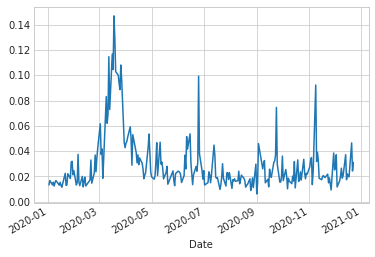

In [ ]:
plt.style.use('seaborn-whitegrid')
l.plot()
plt.show

In [ ]:
def multi_days_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, hldays=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    hldays = defines high-low resolution, eg default hldays = 2, highest and lowest price of every 2 days
    '''
    result = {}
    nh = []; nl = []
    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare 2020 stocks' volatility by calculating std of (high-low) across hldays and remove extreme volatile days
    hldays is the high low resolution in days  '''
    
    for i in stocklist:
        for j in range(0, len(dataframe_hl[i + '-high']), hldays):
            nh.append(np.nanmax(dataframe_hl[i + '-high'][j:j+hldays]))
            nl.append(np.nanmin(dataframe_hl[i + '-low'][j:j+hldays]))

        l = np.divide(np.subtract(nh,nl),nh)
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
        nh = []; nl = []
    return result


In [ ]:
m_days_vol_rank = multi_days_vol_rank(stock, df_hl, hldays=3).items()
{k: v for k, v in sorted(m_days_vol_rank, key=lambda item: item[1], reverse=True)}
#print(m_days_vol_rank)

{'FDS': 0.026894438916777272,
 'SPGI': 0.026435561316978266,
 'TRI': 0.02077291179488036}

In [ ]:
print(multi_days_vol_rank(stock, hldays=3))

{'TRI': 0.02080984124383564, 'FDS': 0.026894438916777272, 'SPGI': 0.026446189574329548}


In [ ]:
# volatity = high - low / high
nh = []; nl = []

for j in range(0, len(df_hl['NOK-high']), 3):
    nh.append(np.nanmax(df_hl['NOK-high'][j:j+3]))
    nl.append(np.nanmin(df_hl['NOK-high'][j:j+3]))
l = np.divide(np.subtract(nh, nl), nh)
m = sorted(l)
print(m)
print(np.std(m[2:-2]))


[0.0, 0.0, 0.0, 0.002320128115414508, 0.0027855127304566327, 0.003937004178520325, 0.005797095840604812, 0.005905459334988622, 0.006607870754022395, 0.006756803923811303, 0.0069444927352426905, 0.007246312545574519, 0.007335014349416929, 0.007782093947869452, 0.007915559813120093, 0.007984119134284571, 0.00915330958822437, 0.011312260151992382, 0.011876529758149556, 0.011904694325796505, 0.011904694325796505, 0.013186904857471808, 0.013927563652283164, 0.014634132725648943, 0.015075362435176206, 0.015424210688960417, 0.01694919363721445, 0.017031671383796472, 0.01715678826793574, 0.017587922841038908, 0.017676750648606902, 0.017964055186050373, 0.01847573328305803, 0.019999980926513672, 0.02045457969027043, 0.021526444352311918, 0.021582770009893514, 0.02178220383361953, 0.021844582099671467, 0.02233254290380562, 0.022922614179784414, 0.023346281843608353, 0.024752451875445412, 0.024875598285331528, 0.025252561133292602, 0.025345651992388186, 0.025936574474714747, 0.026666641235351562,

In [ ]:
abc = [1,2,3]
bcd = [4,5,6]
np.subtract(abc, bcd)

array([-3, -3, -3])

In [ ]:
df_hl.loc['20200501']['MRVL-high']

26.3700008392334

In [ ]:
transactionDate = df_hl.index
transactionDate[10]

Timestamp('2020-01-16 00:00:00')

In [ ]:
Entry = []; Exit = []
flag = 1 #  1 for buy, -1 for sell
df_hl.loc['20200501':'20200506'][['MSI-low', 'MSI-high']]

for i in df_hl.index:
    print(df_hl.loc[i]['MSI-low'])


In [ ]:
# 5% trailing-stop
buy_signal = [np.nan]; sell_signal = [np.nan]
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df_hl['FDS-low'][0]
transactionDate = df_hl.index

for i in range(len(df_hl['FDS-high'])-1):
    if flag == 1:
        bottom = min(bottom, df_hl['FDS-low'][i+1])
        sell_signal.append(np.nan)
        # print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
        if df_hl['FDS-low'][i+1] <= bottom*1.05 < df_hl['FDS-high'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*1.05)
            print(transactionDate[i+1], " buy @ ", bottom*1.05)
            flag = -1
            ceiling = df_hl['FDS-high'][i+1]
        else:
            buy_signal.append(np.nan)
            
    elif flag == -1:
        ceiling = max(ceiling, df_hl['FDS-high'][i+1])
        buy_signal.append(np.nan)
        # print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
        if df_hl['FDS-low'][i+1] <= ceiling/1.05 < df_hl['FDS-high'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.05)
            print(transactionDate[i+1], "sell @ ", ceiling/1.05)
            flag = 1
            bottom = df_hl['FDS-low'][i+1]
        else:
            sell_signal.append(np.nan)


2020-01-17 00:00:00  buy @  276.9375
2020-02-10 00:00:00 sell @  285.019037155878
2020-02-14 00:00:00  buy @  299.25
2020-02-24 00:00:00 sell @  295.4761904761905
2020-03-02 00:00:00  buy @  275.5620025634766
2020-03-06 00:00:00 sell @  280.2952357700893
2020-03-09 00:00:00  buy @  262.0169929504395
2020-03-10 00:00:00 sell @  259.2190406436012
2020-03-11 00:00:00  buy @  261.11399230957034
2020-03-26 00:00:00 sell @  254.3809581938244


In [ ]:
signals = pd.DataFrame()
signals['Buy'] = buy_signal
signals['Sell'] = sell_signal
i = df_hl.index
signals['date'] = i
signals = signals.set_index('date')

In [ ]:
def trailing_stop_signals(df_hl, trailing_pc):
    '''input high low dataframe and trailing percentage eg for 2%, trailing_pc=2)'''
    tpc = trailing_pc/100 + 1
    buy_signal = [np.nan]; sell_signal = [np.nan]
    flag = 1 #  1 for buy, -1 for sell
    ceiling = 0 
    bottom = df_hl['low'][0]
    transactionDate = df_hl.index

    for i in range(len(df_hl['high'])-1):
        if flag == 1:
            bottom = min(bottom, df_hl['low'][i+1])
            sell_signal.append(np.nan)
            #print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
            if df_hl['low'][i+1] <= bottom*tpc < df_hl['high'][i+1]: # limit order hit the next day
                buy_signal.append(bottom*tpc)
                print(transactionDate[i+1], " buy @ ", bottom*tpc)
                flag = -1
                ceiling = df_hl['high'][i+1]
            else:
                buy_signal.append(np.nan)
                
        elif flag == -1:
            ceiling = max(ceiling, df_hl['high'][i+1])
            buy_signal.append(np.nan)
            #print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
            if df_hl['low'][i+1] <= ceiling/tpc < df_hl['high'][i+1]: # stop loss order now hit next day
                sell_signal.append(ceiling/tpc)
                print(transactionDate[i+1], "sell @ ", ceiling/tpc)
                flag = 1
                bottom = df_hl['low'][i+1]
            else:
                sell_signal.append(np.nan)

                
    df_hl['Buy'] = buy_signal
    df_hl['Sell'] = sell_signal
    
    return df_hl

In [ ]:
df = web.DataReader('FDS', data_source='yahoo', start='01-01-2020')
df_hl=pd.DataFrame()
df_hl['high'] = df['High']
df_hl['low'] = df['Low']
df_hl=trailing_stop_signals(df_hl, trailing_pc=5)

2019-08-08 00:00:00  buy @  279.3629974365235
2019-08-14 00:00:00 sell @  269.1333298456101
2019-09-12 00:00:00  buy @  275.0264923095703
2019-09-23 00:00:00 sell @  276.1714390345982
2019-09-26 00:00:00  buy @  251.7375
2019-09-27 00:00:00 sell @  242.57142566499255
2019-10-11 00:00:00  buy @  244.74449615478517
2019-11-08 00:00:00 sell @  248.26665969122024
2019-11-14 00:00:00  buy @  257.6280006408692
2019-12-19 00:00:00 sell @  262.6952253069196
2019-12-27 00:00:00  buy @  270.5639923095703
2020-02-10 00:00:00 sell @  285.019037155878
2020-02-14 00:00:00  buy @  299.25
2020-02-24 00:00:00 sell @  295.4761904761905
2020-03-02 00:00:00  buy @  275.5620025634766
2020-03-06 00:00:00 sell @  280.2952357700893
2020-03-09 00:00:00  buy @  262.0169929504395
2020-03-10 00:00:00 sell @  259.2190406436012
2020-03-11 00:00:00  buy @  261.11399230957034
2020-03-26 00:00:00 sell @  254.3809581938244


Back test Profit and Loss

In [ ]:
# always 100 shares
(df_hl['Sell'].sum()- df_hl['Buy'].sum())*100

-377.7924891880957

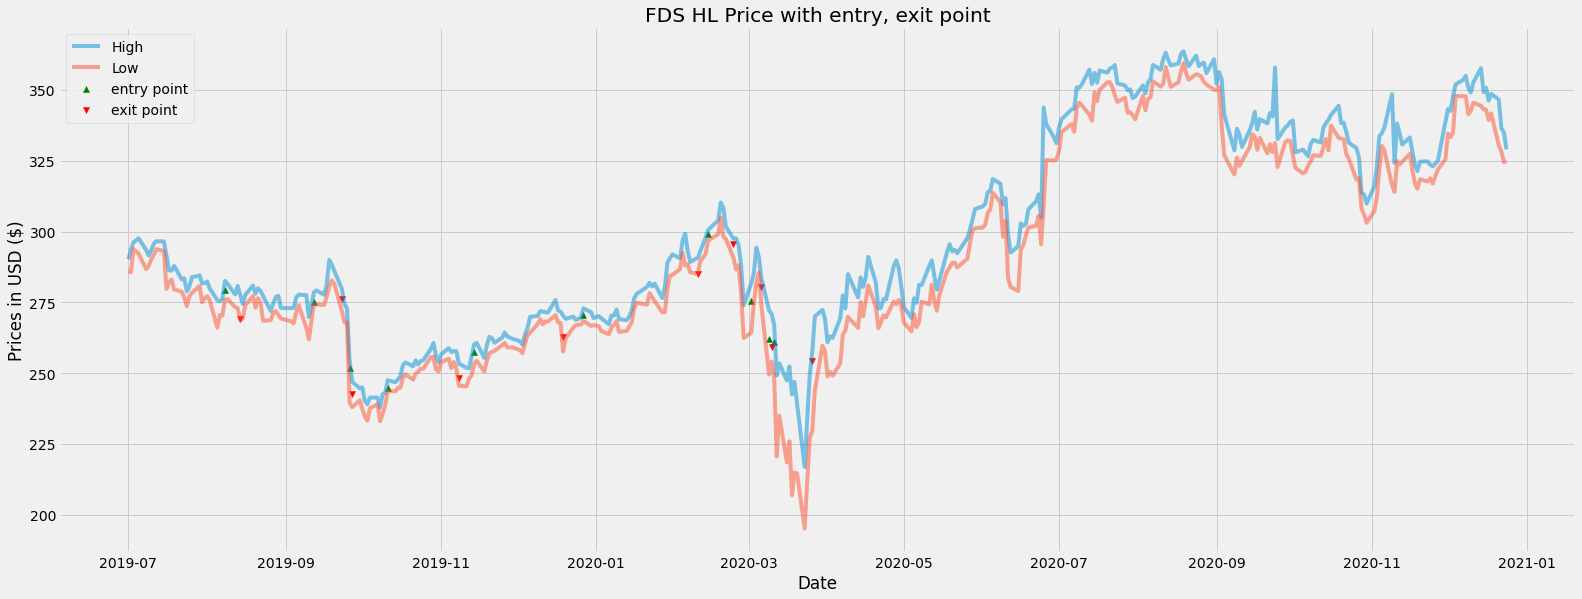

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24.2,9))
plt.plot(df_hl['high'], label = 'High', alpha = 0.5)
plt.plot(df_hl['low'], label = 'Low', alpha = 0.5)
plt.scatter(df_hl.index, df_hl['Buy'], color = 'green', label = 'entry point', marker = '^', alpha = 1)
plt.scatter(df_hl.index, df_hl['Sell'], color = 'red', label = 'exit point', marker = 'v', alpha = 1)
plt.title('FDS HL Price with entry, exit point')
plt.xlabel('Date')
plt.ylabel('Prices in USD ($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['high'],
                    mode='lines',
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['low'],
                    mode='lines',
                    name='Lows'))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['Buy'],
                    mode='markers',
                    name='buy',
                    text=df_hl['Buy']))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['Sell'],
                    mode='markers',
                    name='sell',
                    text=df_hl['Sell']))

fig.show()

<h1>Trailing stop v2</h1>

In [40]:
buy_signal = [np.nan]; sell_signal = [np.nan]
#sellline=[np.nan]; buyline = []
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df_hl['FDS-low'][0]
buyline.append(bottom)
transactionDate = df_hl.index

for i in range(len(df_hl['FDS-high'])-1):
    if flag == 1:
        bottom = min(bottom, df_hl['FDS-low'][i+1])
        sell_signal.append(np.nan)
        #buyline.append(bottom*1.05)
        #sellline.append(np.nan)
        print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.05)
        if df_hl['FDS-low'][i+1] <= bottom*1.05 < df_hl['FDS-high'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*1.05)
            print(transactionDate[i+1], " buy @ ", bottom*1.05)
            flag = -1
            ceiling = df_hl['FDS-high'][i+1]
        else:
            buy_signal.append(np.nan)
            if df_hl['FDS-low'][i+1] > bottom*1.05:
              print("Price up quicker by:", (df_hl['FDS-low'][i+1] - bottom*1.05) / bottom*1.05 * 100, "%" )
            elif bottom*1.05 >= df_hl['FDS-high'][i+1]:
              print("Price down quicker by", (bottom*1.05 - df_hl['FDS-high'][i+1]) / bottom*1.05 * 100, "%" )

            
    elif flag == -1:
        ceiling = max(ceiling, df_hl['FDS-high'][i+1])
        buy_signal.append(np.nan)
        #buyline.append(np.nan)
        #sellline.append(ceiling/1.05)
        print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.05)
        if df_hl['FDS-low'][i+1] <= ceiling/1.05 < df_hl['FDS-high'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.05)
            print(transactionDate[i+1], "sell @ ", ceiling/1.05)
            flag = 1
            bottom = df_hl['FDS-low'][i+1]
        else:
            sell_signal.append(np.nan)

2020-01-03 00:00:00  bottom =  264.8699951171875  entry level =  278.1134948730469
Price down quicker by 3.462137901157472 %
2020-01-06 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 3.8367347174911135 %
2020-01-07 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 2.622509418505628 %
2020-01-08 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 2.6105667765106637 %
2020-01-09 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 1.7745453893290877 %
2020-01-10 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 3.116166969046209 %
2020-01-13 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 3.2714213149807465 %
2020-01-14 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 2.7618483412322274 %
2020-01-15 00:00:00  bottom =  263.75  entry level =  276.9375
Price down quicker by 1.8661137440758295 %
2020-01-16 00:00:00  bottom =

In [35]:
df_hl['FDS_Buy'] = buy_signal
df_hl['FDS_Sell'] = sell_signal
df_hl['FDS_buyline'] = buyline
df_hl['FDS_sellline'] = sellline

df_hl

,TRI-high,TRI-low,FDS-high,FDS-low,SPGI-high,SPGI-low,FDS_Buy,FDS_Sell,FDS_buyline,FDS_sellline
Date,,,,,,,,,,
2019-06-03,64.089996,63.490002,279.019989,273.809998,216.029999,211.350006,NaN,NaN,273.809998,NaN
2019-06-04,64.029999,63.029999,285.119995,277.350006,215.740005,210.490005,NaN,NaN,287.500497,NaN
2019-06-05,65.529999,63.730000,287.959991,283.130005,220.889999,216.169998,287.500497,NaN,287.500497,NaN
2019-06-06,65.849998,64.839996,291.480011,285.820007,222.449997,220.369995,NaN,NaN,NaN,277.600010
2019-06-07,66.879997,66.000000,295.230011,290.510010,225.220001,222.039993,NaN,NaN,NaN,281.171439
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,80.629997,79.470001,329.029999,324.760010,316.940002,313.230011,NaN,NaN,241.195507,NaN
2020-12-28,81.150002,80.669998,332.269989,327.790009,319.019989,314.369995,NaN,NaN,241.195507,NaN
2020-12-29,82.000000,81.190002,332.880005,326.739990,322.910004,319.790009,NaN,NaN,241.195507,NaN


In [36]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS-high'],
                    mode='lines',
                    line=dict(color='blue', width=0.8),
                    opacity=0.5,
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS-low'],
                    mode='lines',
                    line=dict(color='red', width=0.8),
                    opacity=0.5,
                    name='Lows'))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_Buy'],
                    mode='markers',
                    name='buy',
                    text=df_hl['FDS_Buy']))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_Sell'],
                    mode='markers',
                    name='sell',
                    text=df_hl['FDS_Sell']))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_buyline'],
                    mode='lines',
                    #line=dict(color='blue', width=0.8),
                    #opacity=0.5,
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_sellline'],
                    mode='lines',
                    #line=dict(color='red', width=0.8),
                    #opacity=0.5,
                    name='Lows'))


fig.show()